# Importy

In [1]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import scipy
#import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.statespace as stspace
from statsmodels.tsa.stattools import pacf, acf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima

# Ładowanie danych

In [3]:
path = 'https://raw.githubusercontent.com/annaStykowska/Time-series-analysis-including-NN-/main/Monthly-hourly-load-values_2006-2015.xlsx'
# wczytanie danych
data=pd.read_excel(path, header=3)
data = data.iloc[3:]
dataPL=data.loc[data['Country']=='PL']
# utworzenie daty z pojedynczych kolumn do innej kolumny
dataPL.rename(columns = {'Year':'year', 'Month':'month','Day':'day'}, inplace = True)
dataPL['date']=pd.to_datetime(dataPL[['year','month','day']])
# usunięcie niepotrzebnych kolumn
dataPL=dataPL.drop(['Country','year','month','day','Coverage ratio'],axis=1)
dataPL['load']=dataPL.iloc[:,:-1].sum(axis=1)
# uzupełnienie braków - ta sama kolumna, opóźnienie o 7 -> godzina 2 z tygodnia wcześniej
dataPL.fillna(dataPL.shift(7), inplace=True)
# dane treningowe, indeks data
trainPL = dataPL.loc[dataPL['date'] < '2013-01-01']
trainPL = trainPL.set_index("date")
trainPL.index = pd.to_datetime(trainPL.index)
# dane testowe, indeks data
testPL = dataPL.loc[dataPL['date'] >= '2013-01-01']
testPL = testPL.set_index("date")
testPL.index = pd.to_datetime(testPL.index)
dataPL = dataPL.set_index("date")
dataPL.index = pd.to_datetime(dataPL.index)

In [4]:
trainARIMA = trainPL['load']
testARIMA = testPL['load']

# Dekompozycja, stacjonarność

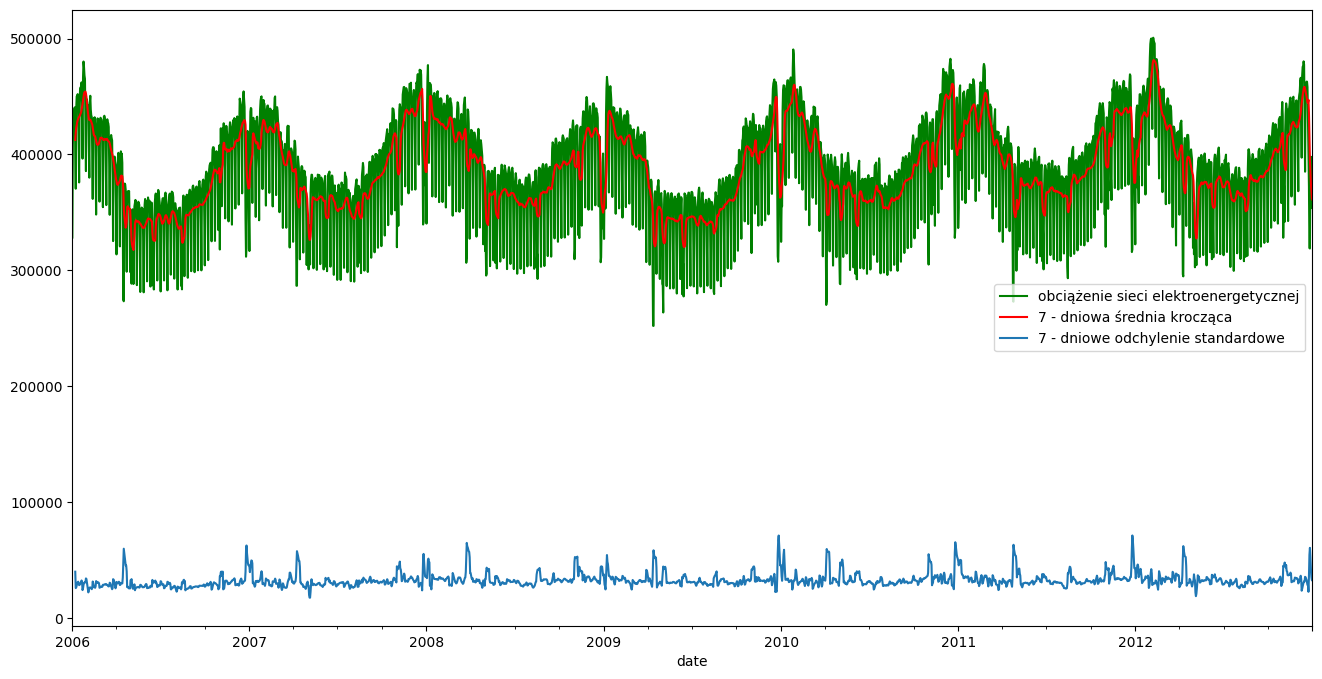

In [5]:
trainARIMA.plot(label='obciążenie sieci elektroenergetycznej',color='green')
trainARIMA.rolling(7).mean().plot(label='7 - dniowa średnia krocząca',figsize=(16,8),color='red')
trainARIMA.rolling(7).std().plot(label='7 - dniowe odchylenie standardowe')
plt.legend()

In [6]:
trainARIMA.values

array([328276., 408152., 432641., ..., 385422., 353598., 363895.])

In [7]:
# dekompozycja szeregu: 7 - dniowa oraz 365 - dniowa
x_val = trainARIMA.values
season_decomp7 = seasonal_decompose(trainARIMA, model='additive', period=7)
season_decomp365 = seasonal_decompose(trainARIMA, model='additive', period=365)

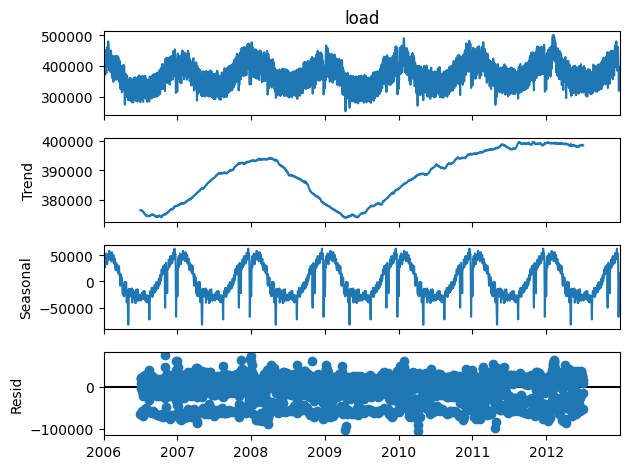

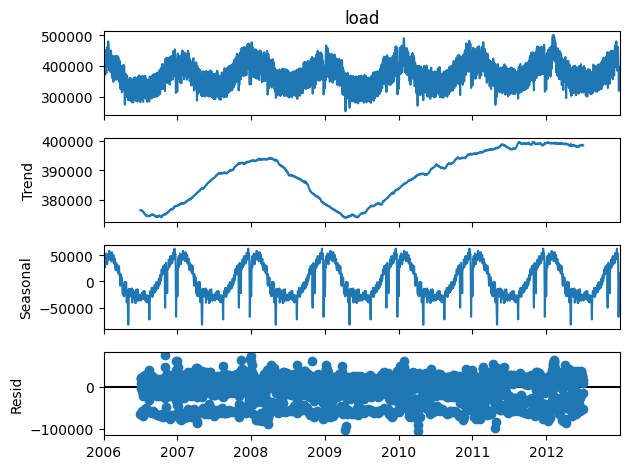

In [8]:
# wykres dekompozycji 365-dniowej
season_decomp365.plot()

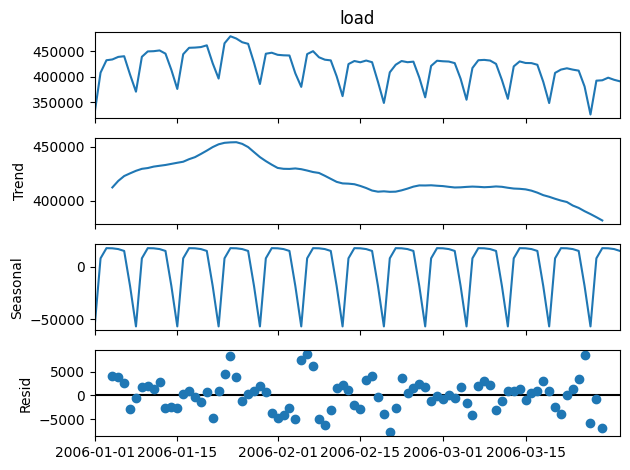

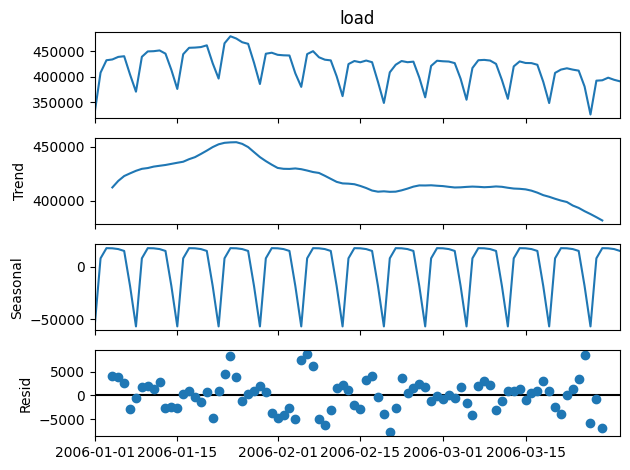

In [9]:
# wykres dekompozycji 7 - dniowej na przedziale 3 miesięcy
season_decomp3mies = seasonal_decompose(trainARIMA[0:90], model='additive',period=7)
season_decomp3mies.plot()

<Axes: xlabel='date'>

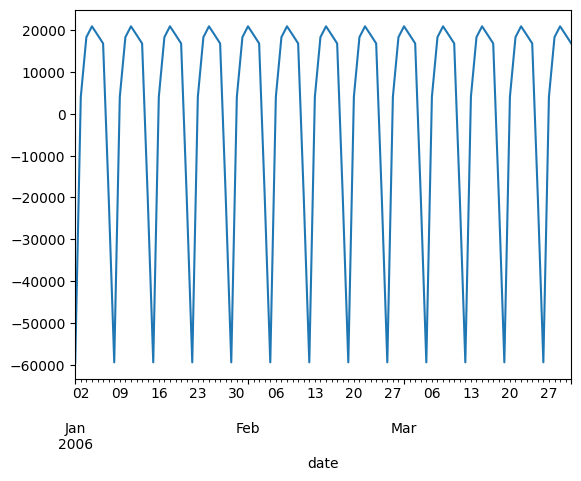

In [10]:
# sezonowość tygodniowa
season_decomp7.seasonal[0:90].plot()

<Axes: xlabel='date'>

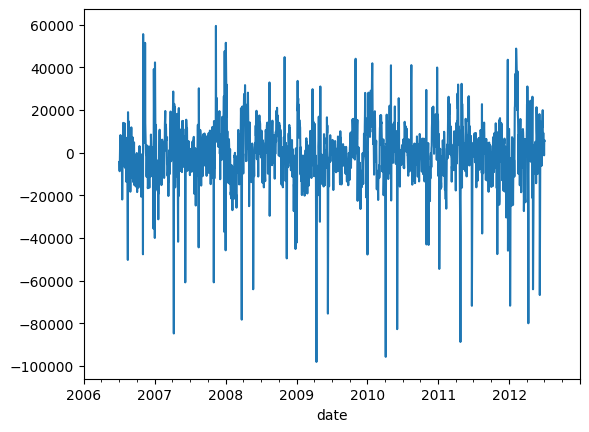

In [11]:
# badany szereg po usunięciu sezonowości i trendu rocznego
trainARIMA_des7 = trainARIMA - season_decomp7.seasonal - season_decomp365.seasonal - season_decomp365.trend
trainARIMA_des7.plot()

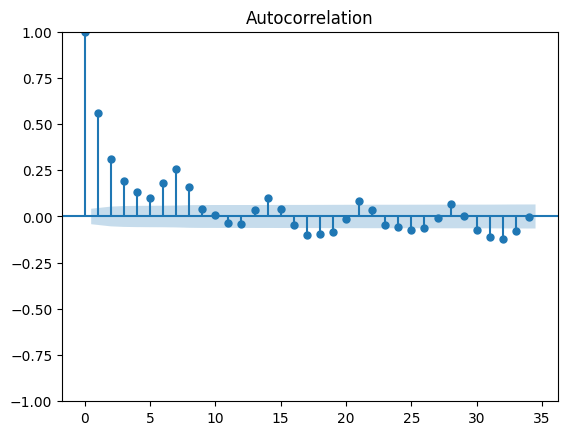

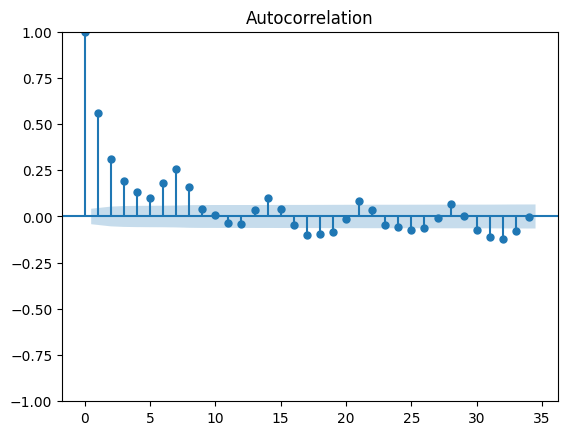

In [12]:
# autokorelacja
plot_acf(trainARIMA_des7.dropna())

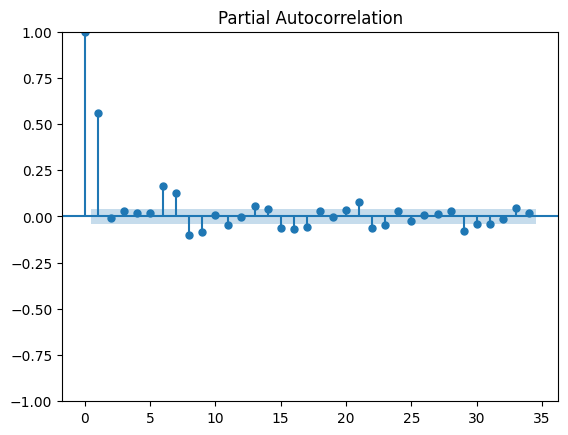

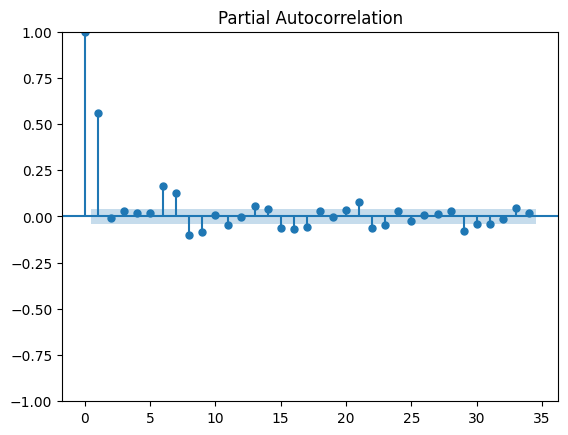

In [13]:
# cząstkowa autokorelacja
plot_pacf(trainARIMA_des7.dropna())

In [14]:
# sprawdzenie czy szereg jest stacjonarny
result = adfuller(trainARIMA_des7.dropna())
print('statystyka ADF: %f' % result[0])
print('p-wartość: %f' % result[1])
# H0: szereg nie jest stacjonarny
# Szereg stacjonarny

statystyka ADF: -9.462832
p-wartość: 0.000000


In [15]:
# sprawdzenie czy szereg jest stacjonarny
result = kpss(trainARIMA_des7.dropna(), regression='ct')
print('statystyka KPSS: %f' % result[0])
print('p-wartość: %f' % result[1])
# P Value > 0.05 H0: szereg jest stacjonarny
# SZEREG STACJONARNY

statystyka KPSS: 0.041787
p-wartość: 0.100000


<ipython-input-15-3a01dce460e3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(trainARIMA_des7.dropna(), regression='ct')


# ARMA (1,7)

In [16]:
# 1,0,7 ARIMA Model
model = ARIMA(trainARIMA_des7.dropna(), order=(1,0,7))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2193
Model:                 ARIMA(1, 0, 7)   Log Likelihood              -23609.342
Date:                Sat, 07 Oct 2023   AIC                          47238.683
Time:                        10:04:10   BIC                          47295.613
Sample:                    07-02-2006   HQIC                         47259.489
                         - 07-02-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.0548    770.111      0.086      0.932   -1443.334    1575.444
ar.L1          0.6372      0.066      9.675      0.000       0.508       0.766
ma.L1         -0.0957      0.067     -1.422      0.1

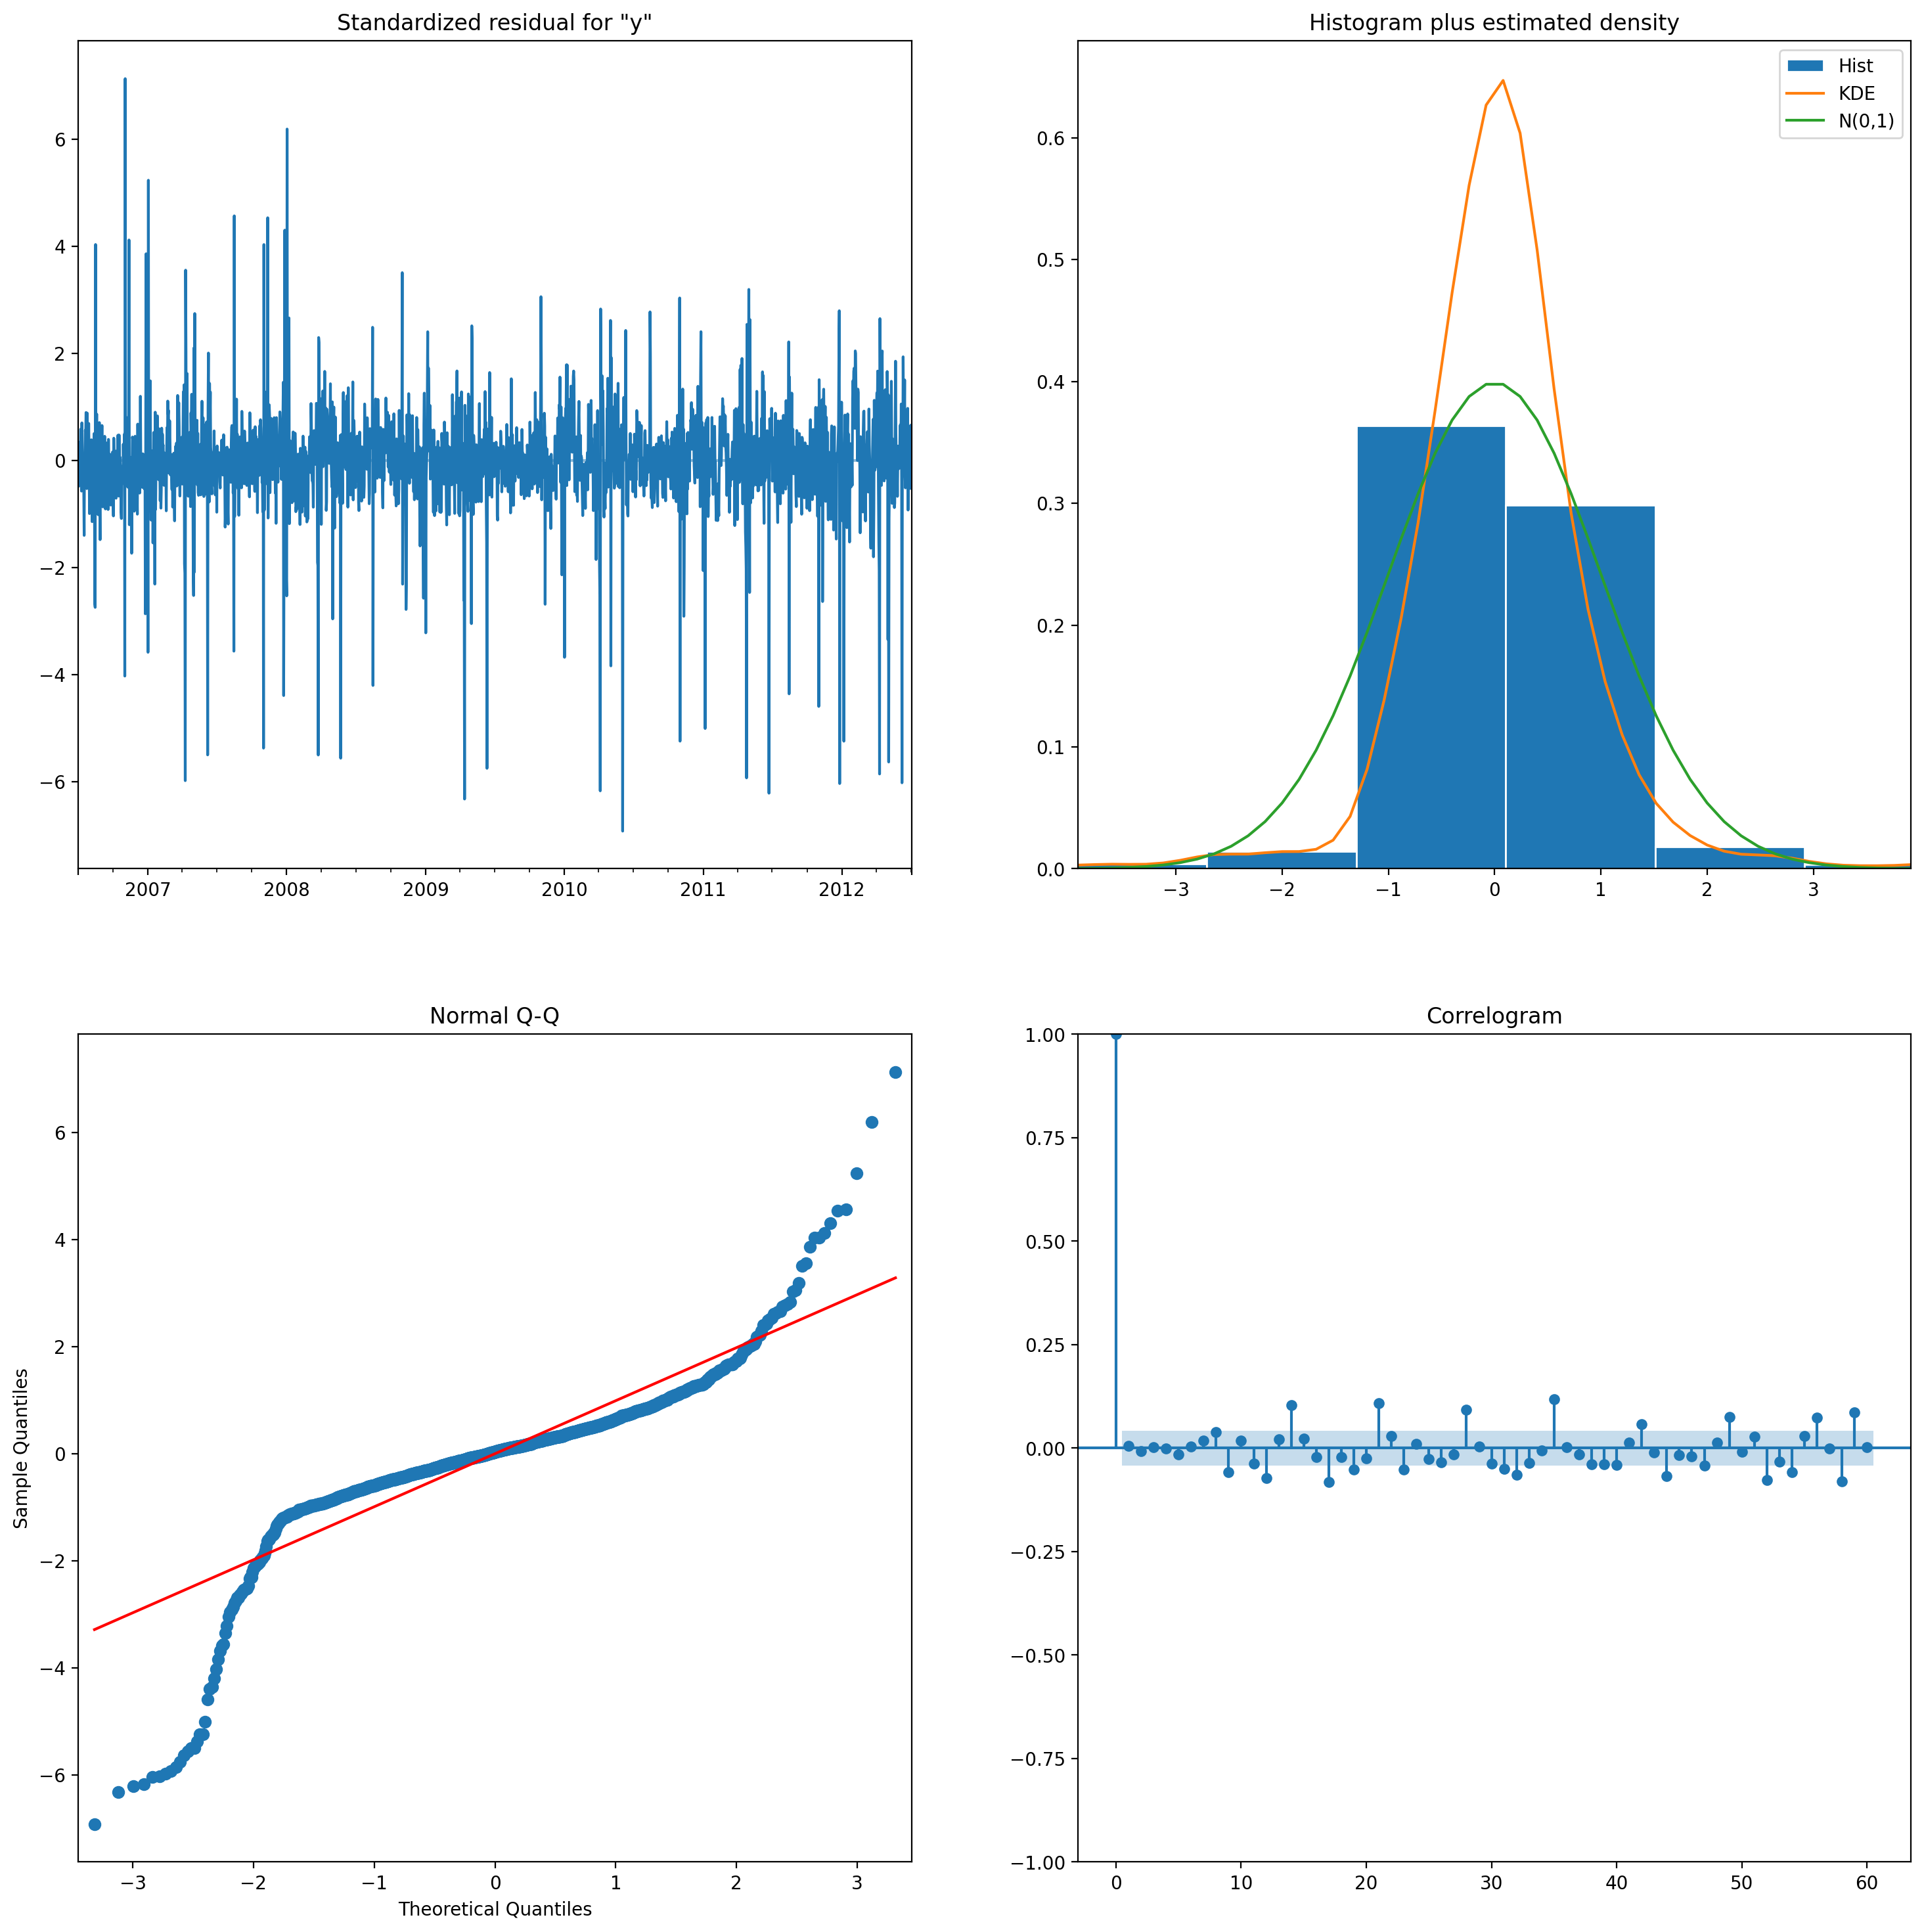

In [17]:
# wykresy diagnostyczne reszt
model_fit.plot_diagnostics(figsize=(18,18),lags=60).set_dpi(200);
plt.show(); # residua nie są skorelowane, mają średnią 0, ale nie są normalne -> ok -> white noise

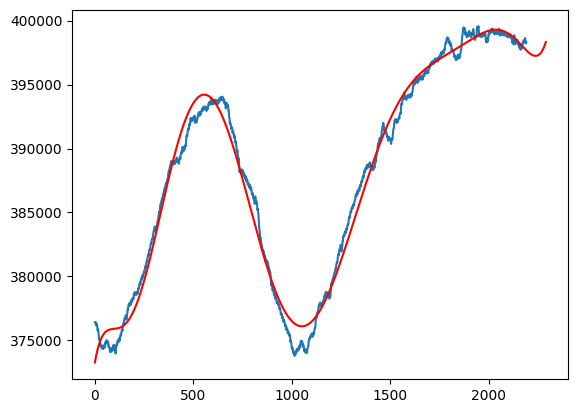

In [18]:
# dopasowanie wielomianu do aktualnego trendu
X = [i for i in range(0, len(season_decomp365.trend.dropna()))]
X = np.array(X).reshape(-1)
y = season_decomp365.trend.dropna().values
coef = np.polyfit(X, y, 9)
poly = np.poly1d(coef)
plt.plot(X, y)
dl_pred = 100
poly_x = range(X[0], X[-1] + dl_pred)
poly_y = poly(poly_x)
plt.plot(poly_x, poly_y, color="red")
plt.show()

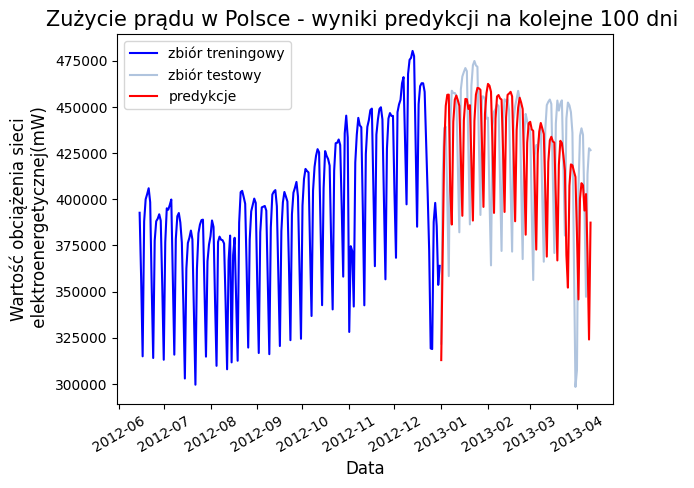

In [19]:
start_index = pd.datetime(2013, 1, 1)
end_index = pd.datetime(2015, 12, 31)
forecast = model_fit.predict(start=start_index, end=end_index)
# arima_pred: predykcja 100 wartości
arima_pred = forecast[:dl_pred] +season_decomp7.seasonal[:dl_pred].values + season_decomp365.seasonal[:dl_pred].values + poly_y[-dl_pred:]
# plot
plt.plot(trainARIMA[-200:],label='zbiór treningowy',color='blue')
plt.plot(testARIMA[:100], label='zbiór testowy',color='lightsteelblue')
plt.plot(arima_pred,label='predykcje',color='red')
plt.xlabel("Data",fontsize=12)
plt.xticks(rotation=30)
plt.ylabel("Wartość obciążenia sieci\n elektroenergetycznej(mW)",fontsize=12)
plt.title("Zużycie prądu w Polsce - wyniki predykcji na kolejne 100 dni ",fontsize=15)
plt.legend()
plt.show()

In [20]:
rmse = []
mse = []
me_err = []
mae_err = []
mape_err = []
dif = []

n=0
horizons = [7,14,30,60,90]
for horizon in horizons:
    rmse.append(np.round(np.sqrt(np.mean(pow((np.array(testARIMA[:horizon])-np.array(arima_pred[:horizon])),2))),2))
    me_err.append(np.round(np.mean(np.array(testARIMA[:horizon])-np.array(arima_pred[:horizon])),2))
    mae_err.append(np.round(np.mean(np.abs(np.array(testARIMA[:horizon])-np.array(arima_pred[:horizon]))),2))
    mape_err.append(np.mean(np.abs((np.array(testARIMA[:horizon])-np.array(arima_pred[:horizon]))/np.array(testARIMA[:horizon]))))
    dif.append(np.array(testARIMA[:horizon])-np.array(arima_pred[:horizon]))

# seasonal ARIMA

In [21]:
# auto arima sezon 7
mSarima = auto_arima(trainARIMA,
                   seasonal=True,
                   m = 7,
                   trace=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=8.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=60803.487, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=59094.309, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=59725.524, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=60801.488, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=60805.168, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=58981.460, Time=1.38 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=9.26 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=58245.935, Time=4.38 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=59734.569, Time=0.59 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=7.68 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=59436.178, Time=1.00 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=8.46 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=58013.780, Time=3.91 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5

In [22]:
mSarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2557
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood              -28810.599
Date:                             Sat, 07 Oct 2023   AIC                          57631.197
Time:                                     10:05:49   BIC                          57660.428
Sample:                                 01-01-2006   HQIC                         57641.798
                                      - 12-31-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    214.4923    350.583      0.612      0.541    -472.638     901.623
ar.S.L7        0.4269      0.013     31.919      0.000       0.401       0.453
ar.S.L14       0.5114      0.010     50.841      0.000       0.492       0.531
ma.S.L7       -0.2105      0.022     -9.740      0.000      -0.253      -0.168
sigma2      4.033e+08      0.000   9.93e+11      0.000    4.03e+08    4.03e+08
===================================================================================
Ljung-Box (L1) (Q):                  13.57   Jarque-Bera (JB):             54095.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.93e+27. Standard errors may be unstable.
"""

In [23]:
#ARIMA(0, 1, 1)x(1, 0, 1, 7)
sarima = sm.tsa.statespace.SARIMAX(trainARIMA,
                         order=(0, 1, 1),
                         seasonal_order=(1, 0, 1, 7))
sarimaResult = sarima.fit(method = 'powell')
print(sarimaResult.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 11.105612
         Iterations: 6
         Function evaluations: 291
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0888      0.006    -14.133      0.000      -0.101      -0.077
ar.S.L7        0.9994      0.000   2300.893      0.000       0.999       1.000
ma.S.L7       -0.9800      0.007   -144.007      0.000      -0.993      -0.967
sigma2      2.627e+08   2.14e-12   1.23e+20      0.000    2.63e+08    2.63e+08


Niestety, automatyczna ARIMA sezonowa bardzo się gubi przy chwilowym spadku wartości:

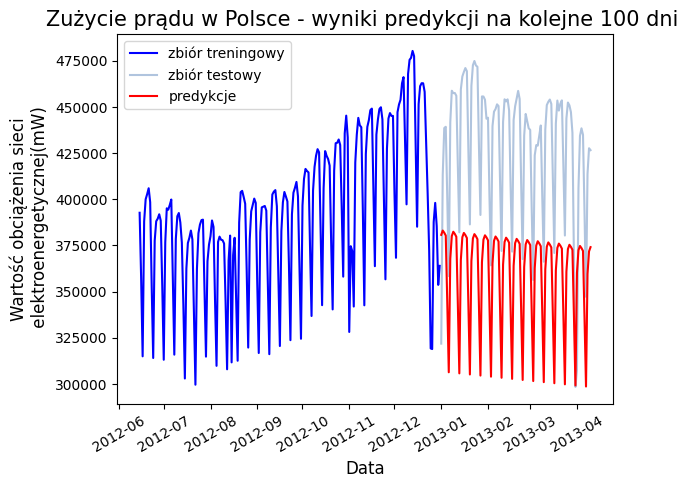

In [24]:
# predykcja 100 wartości
dl_pred=100
forecast = sarimaResult.get_forecast(steps=dl_pred)
plt.plot(trainARIMA[-200:],label='zbiór treningowy',color='blue')
plt.plot(testARIMA[:100], label='zbiór testowy',color='lightsteelblue')
plt.plot(forecast.predicted_mean,label='predykcje',color='red')
plt.xlabel("Data",fontsize=12)
plt.xticks(rotation=30)
plt.ylabel("Wartość obciążenia sieci\n elektroenergetycznej(mW)",fontsize=12)
plt.title("Zużycie prądu w Polsce - wyniki predykcji na kolejne 100 dni ",fontsize=15)
plt.legend()
plt.show()